# Traveling Wave Detection (TWD) with density-based clustering algorithms

The purpose of this notebook is to build a traveling wave detection algorithm using density-based clutering methods to collect wave features such as shape, speed, span, ...

In [1]:
%matplotlib widget
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import scipy.ndimage as img
import scipy.signal as signal 
import scipy.stats as stat
from sklearn.cluster import HDBSCAN, DBSCAN, OPTICS
from alphashape import alphashape
from matplotlib.patches import Polygon as MplPolygon



## Intro

### Data loading and parameters definition

#### Choose the data to work on

Paths

In [2]:
bks_blank_path = r'/media/mathis/Data/Mathis/Original Data/blank_ziggy_210908.npy'
bks_evoked_path = r'/media/mathis/Data/Mathis/Original Data/gaussian_pos4_ziggy_210908.npy'

anesth_blank_path = r'/media/mathis/Data/Mathis/Original Data/signal_240306_blank.mat' #change it to adapt to your directories

awak_pattern_path = r'/media/mathis/Data/Mathis/Original Data/awake_annoted.png'


Loading

In [3]:
#Bks_anesth_blankblank = np.load(bks_blank_path)
Bks_evoked = np.load(bks_evoked_path)

Vasc_pattern = plt.imread(awak_pattern_path)

#file_anesth_blank = h5py.File(anesth_blank_path)['signal']
#anesth_blank = np.array(file_anesth_blank)


In [4]:
Data = Bks_evoked
condition = 'awake' # 'awake' or 'anesthesia'


#### Parameters definition

In [5]:
N_trials, Nt, Nx, Ny = Data.shape
Fs = {'awake':100, 'anesthesia':110} #Hz
pixel_spacing = {'awake':0.0566, 'anesthesia':0.0575} #mm
frames = range(Nt)
label_colors = ['gray','red', 'blue', 'green', 'magenta', 'orange', 'purple', 'black','cyan','pink', 'black', 'cyan', 'yellow', 'chartreuse', 'palegreen', 'tomato', 'coral']

### Trial choice 

In [6]:
trial_number=8
trial = np.copy(Data[trial_number])
mean = np.nanmean(trial)
nan_loc = np.isnan(trial)
trial[nan_loc] = mean


### Pre-processing

#### Border masks

In [7]:
def circular_mask(shape, center, radius):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    return ((X - center[0]) ** 2 + (Y - center[1]) ** 2) <= radius ** 2


In [8]:
mask_awake = circular_mask(trial.shape[1:], center=(220,190), radius=180)
mask_anesth = circular_mask(trial.shape[1:], center=(125,140), radius=130)
border_mask = {'awake':mask_awake, 'anesthesia':mask_anesth}


In [9]:
trial[:, ~border_mask[condition]] = 0


#### Temporal filtering (lowpass 30 Hz)

In [10]:
butt_filt = signal.butter(N=4, Wn=30, btype='lowpass', fs=Fs[condition], output='sos') 
trial_filt=signal.sosfiltfilt(butt_filt, trial, axis=0)


### Visualisation of a wave pattern

In [11]:
frame_number = 28

In [12]:
Image = np.copy(trial_filt[frame_number])
Smooth=img.gaussian_filter(Image, sigma=3, mode='constant')
Blurred = img.median_filter(Image, size=15)


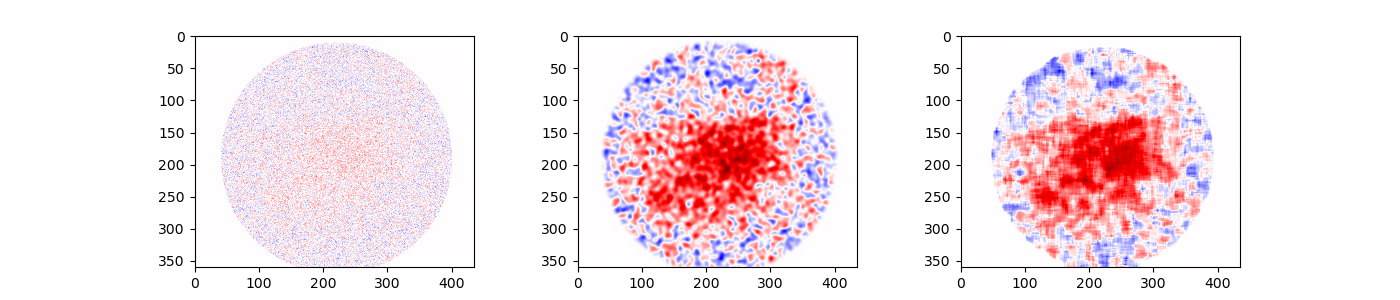

In [13]:
fig, axs = plt.subplots(1,3, figsize=(14,3))
axs[0].imshow(Image, cmap='seismic', vmax=5, vmin=-5)
axs[1].imshow(Smooth, cmap='seismic', vmax=.5, vmin=-.5)
axs[2].imshow(Blurred, cmap='seismic', vmax=.5, vmin=-.5)


## 1: Hot spots thresholding

### Threshold definition

In [14]:
threshold=99 #%
thresh_value=np.percentile(trial_filt, threshold)
print(thresh_value)


1.6320794541427373


In [15]:
trial_thresh = trial_filt - thresh_value
trial_thresh[trial_thresh<0]=0


### Image definition

In [16]:
Image_thresh = np.copy(trial_thresh[frame_number])
Smooth_thresh=img.gaussian_filter(Image_thresh, sigma=5, mode='constant')
Blurred_thresh = img.median_filter(Smooth_thresh, size=15)


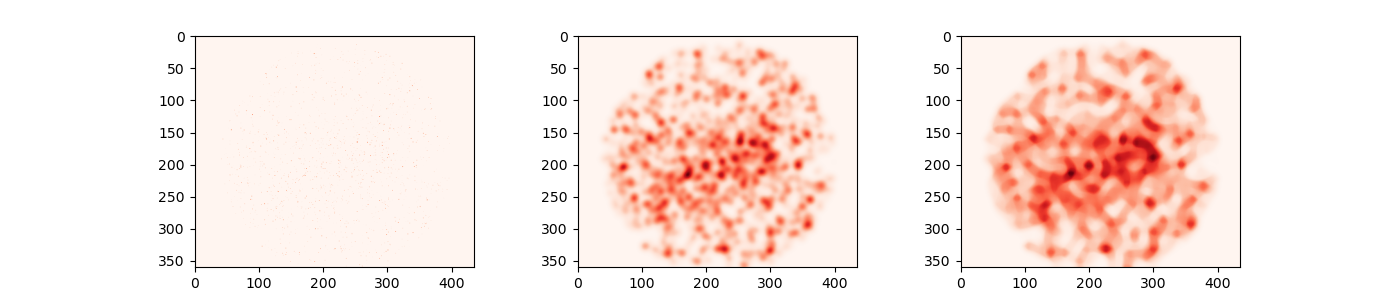

In [17]:
fig, axs = plt.subplots(1,3, figsize=(14,3))
axs[0].imshow(Image_thresh, cmap='Reds')
axs[1].imshow(Smooth_thresh, cmap='Reds')
axs[2].imshow(Blurred_thresh, cmap='Reds')


Select hot points

In [18]:
ind1, ind2 = np.where(Image_thresh>0)
Points = np.vstack((ind1, ind2)).T
Points.shape


(1700, 2)

and their temperatures/weights

In [19]:
val = Image_thresh[ind1, ind2]
val.max()


1.3103015258459827

## 2: Density-based clustering algorithms

### DBSCAN

In [20]:
eps=20
min_samples=32


In [21]:
clust_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labs_dbscan = clust_dbscan.fit_predict(Points)

print(f'{labs_dbscan.max()+1} clusters detected')


3 clusters detected


### HDBSCAN

In [22]:
min_cluster_size=17


In [23]:
clust_hdbscan = HDBSCAN(min_cluster_size=min_cluster_size)
labs_hdbscan = clust_hdbscan.fit_predict(Points)
print(f'{labs_hdbscan.max()+1} clusters detected')


2 clusters detected


### OPTICS

In [24]:
min_samples=20
eps =  25
xi=.05


In [25]:
clust_optics = OPTICS(min_samples=min_samples, xi=xi, eps=eps)
labs_optics = clust_optics.fit_predict(Points)
print(f'{labs_optics.max()+1} clusters detected')


3 clusters detected


### Result of the clustering

Text(0.5, 0.98, 'Detecting blobs of higher activity with density-based clustering algorithms')

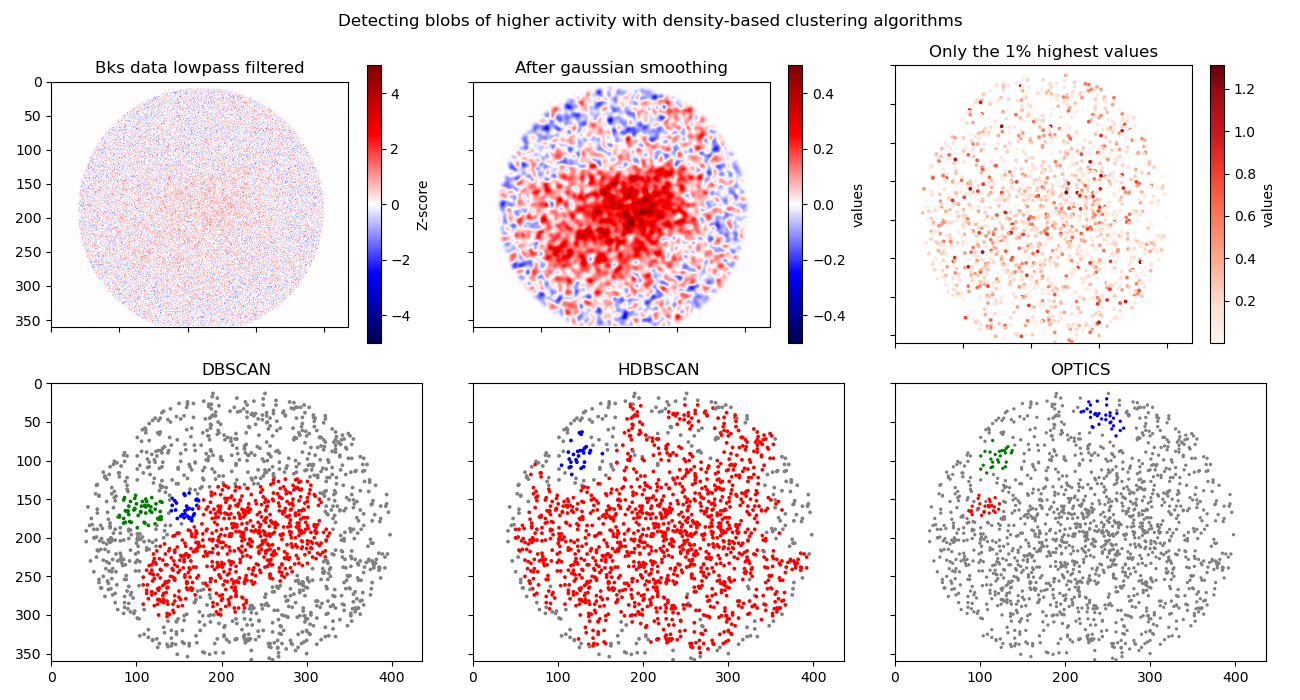

In [26]:
fig, axs = plt.subplots(2,3, figsize=(13,7),sharex=True, sharey=True, tight_layout=True)

im1 = axs[0,0].imshow(Image, cmap='seismic', vmax=5, vmin=-5)
axs[0,0].set_title('Bks data lowpass filtered')

im2 = axs[0,1].imshow(Smooth, cmap='seismic', vmax=.5, vmin=-.5)
axs[0,1].set_title('After gaussian smoothing')

sc1 = axs[0,2].scatter(ind2, ind1, s=3, c=val, cmap='Reds')
axs[0,2].set_xlim(0,Ny)
axs[0,2].set_ylim(0,Nx)
axs[0,2].invert_yaxis()
axs[0,2].set_title(f'Only the {100-threshold}% highest values')

sc2 = axs[1,0].scatter(ind2, ind1, s=3, color=[label_colors[i] for i in labs_dbscan+1])
axs[1,0].set_xlim(0,Ny)
axs[1,0].set_ylim(0,Nx)
axs[1,0].invert_yaxis()
axs[1,0].set_title('DBSCAN')

sc3 = axs[1,1].scatter(ind2, ind1, s=3, color=[label_colors[i] for i in labs_hdbscan+1])
axs[1,1].set_xlim(0,Ny)
axs[1,1].set_ylim(0,Nx)
axs[1,1].invert_yaxis()
axs[1,1].set_title('HDBSCAN')

sc4 = axs[1,2].scatter(ind2, ind1, s=2, color=[label_colors[i] for i in labs_optics+1])
axs[1,2].set_xlim(0,Ny)
axs[1,2].set_ylim(0,Nx)
axs[1,2].invert_yaxis()
axs[1,2].set_title('OPTICS')

fig.colorbar(im1, label='Z-score')
fig.colorbar(im2, label='values')
fig.colorbar(sc1, label='values')

fig.suptitle('Detecting blobs of higher activity with density-based clustering algorithms')


Warning. DBSCAN is a bit rigid but it has the nice property not to detect wide patterns all over the field, unlike HDBSCAN which is too permissive... Do I need to quantify that? maybe just test DBSCAN against non-density based algo

## 3: Clusters shape

To test if two consecutive clusters are similar enough to be considered as belonging to the same moving cluster, we need to analyse their spatial properties. To do so, we can compute the alpha shape of clusters. 

In [27]:
clust_hdbscan_points = [Points[labs_hdbscan == label] for label in np.unique(labs_hdbscan) if label != -1]
clust_dbscan_points = [Points[labs_dbscan == label] for label in np.unique(labs_dbscan) if label != -1]


Choose two clusters that looks similar

In [28]:
point1 = clust_hdbscan_points[0]
point2 = clust_dbscan_points[0]


Alpha shape

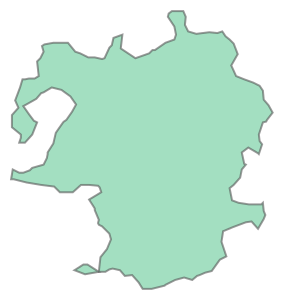

In [29]:
c1 = alphashape(point1, .1)
c1


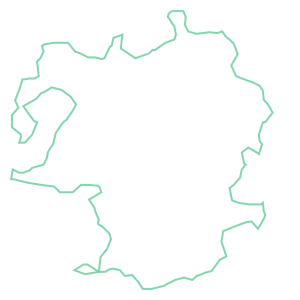

In [30]:
c1.boundary

In [31]:
type(c1)

shapely.geometry.multipolygon.MultiPolygon

In [32]:
type(c1.boundary)

shapely.geometry.multilinestring.MultiLineString

Comparing the shapes of two different clusters

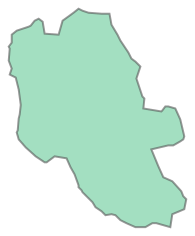

In [33]:
c2 = alphashape(point2, .1)
c2


In [34]:
type(c2)

shapely.geometry.polygon.Polygon

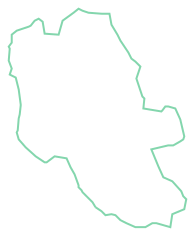

In [35]:
c2.exterior

In [36]:
hh=np.array(c2.exterior.xy)
hh.shape

(2, 89)

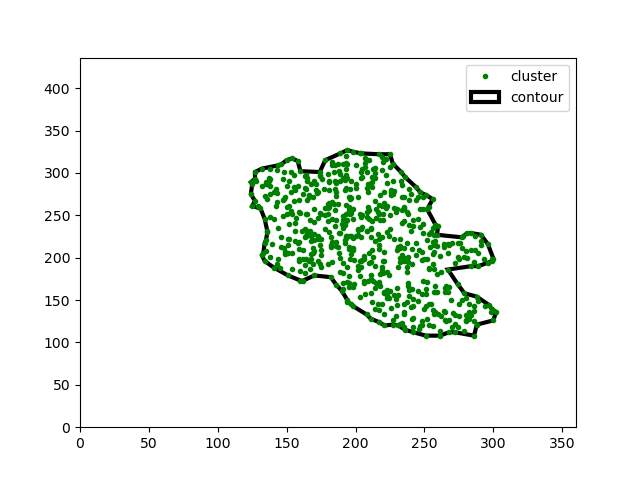

In [37]:
plt.figure()
plt.plot(point2[:,0], point2[:,1], 'g.', label='cluster')
plt.xlim(0,Nx)
plt.ylim(0,Ny)
x, y = c2.exterior.xy
mpl_poly = MplPolygon(list(zip(x, y)), closed=True, edgecolor='k', facecolor='none', label='contour', linewidth=3)
plt.gca().add_patch(mpl_poly)
plt.legend()
plt.show()


### Overlapping Coeficient

In [38]:
inter=c2.intersection(c1)
inter.area


23636.0

In [39]:
uni = c2.union(c1)
uni.area


64304.5

In [40]:
inter.area/uni.area


0.36756370082964646

In [41]:
def valid_moving_cluster(cluster1,cluster2,Theta,alpha):
    polygon1,polygon2 = alphashape(cluster1,alpha),alphashape(cluster2,alpha)
    inter_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area
    return inter_area/union_area>Theta


In [42]:
#test
valid_moving_cluster(point1, point2, alpha=.1,Theta=.5)


False

## 4: Introducing Moving Cluster Detection Algorithm (MCDA)

To look at the original paper from which this algorithm is implemented: https://i.cs.hku.hk/~nikos/67.pdf

### Running MCDA on a single trial

In [150]:
from Detection_functions import MCDA

In [44]:
test_mc=MCDA(trial_thresh,20,32,.50)


frame #0
frame #1
frame #2
frame #3
frame #4
frame #5
frame #6
frame #7
frame #8
frame #9
frame #10
frame #11
frame #12
frame #13
frame #14
frame #15
frame #16
frame #17
frame #18
frame #19
frame #20
frame #21
frame #22
frame #23
frame #24
frame #25
frame #26
frame #27
extension
frame #28
extension
frame #29
extension
frame #30
extension
frame #31
extension
extension
frame #32
extension
frame #33
extension
frame #34
extension
frame #35
extension
frame #36
frame #37
frame #38
frame #39
extension
frame #40
frame #41
frame #42
frame #43
frame #44
frame #45
frame #46
frame #47
frame #48
frame #49
frame #50
frame #51
frame #52
frame #53
frame #54
frame #55
frame #56
frame #57
frame #58
frame #59


In [45]:
len(test_mc)

1

Select the longest moving cluster in the collection

In [46]:
ind_wave=0
print(test_mc[0]['trace'])
for i in range(1,len(test_mc)):
    print(test_mc[i]['trace'])
    if len(test_mc[i]['trace'])>len(test_mc[ind_wave]['trace']):
        ind_wave=i


[26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


In [47]:
central=[]
for i in range(len(test_mc[ind_wave]['trace'])):
    M = np.mean(test_mc[ind_wave]['points'][i],axis=0 )
    central.append(M)
Centre=np.array(central)


### Detection plot

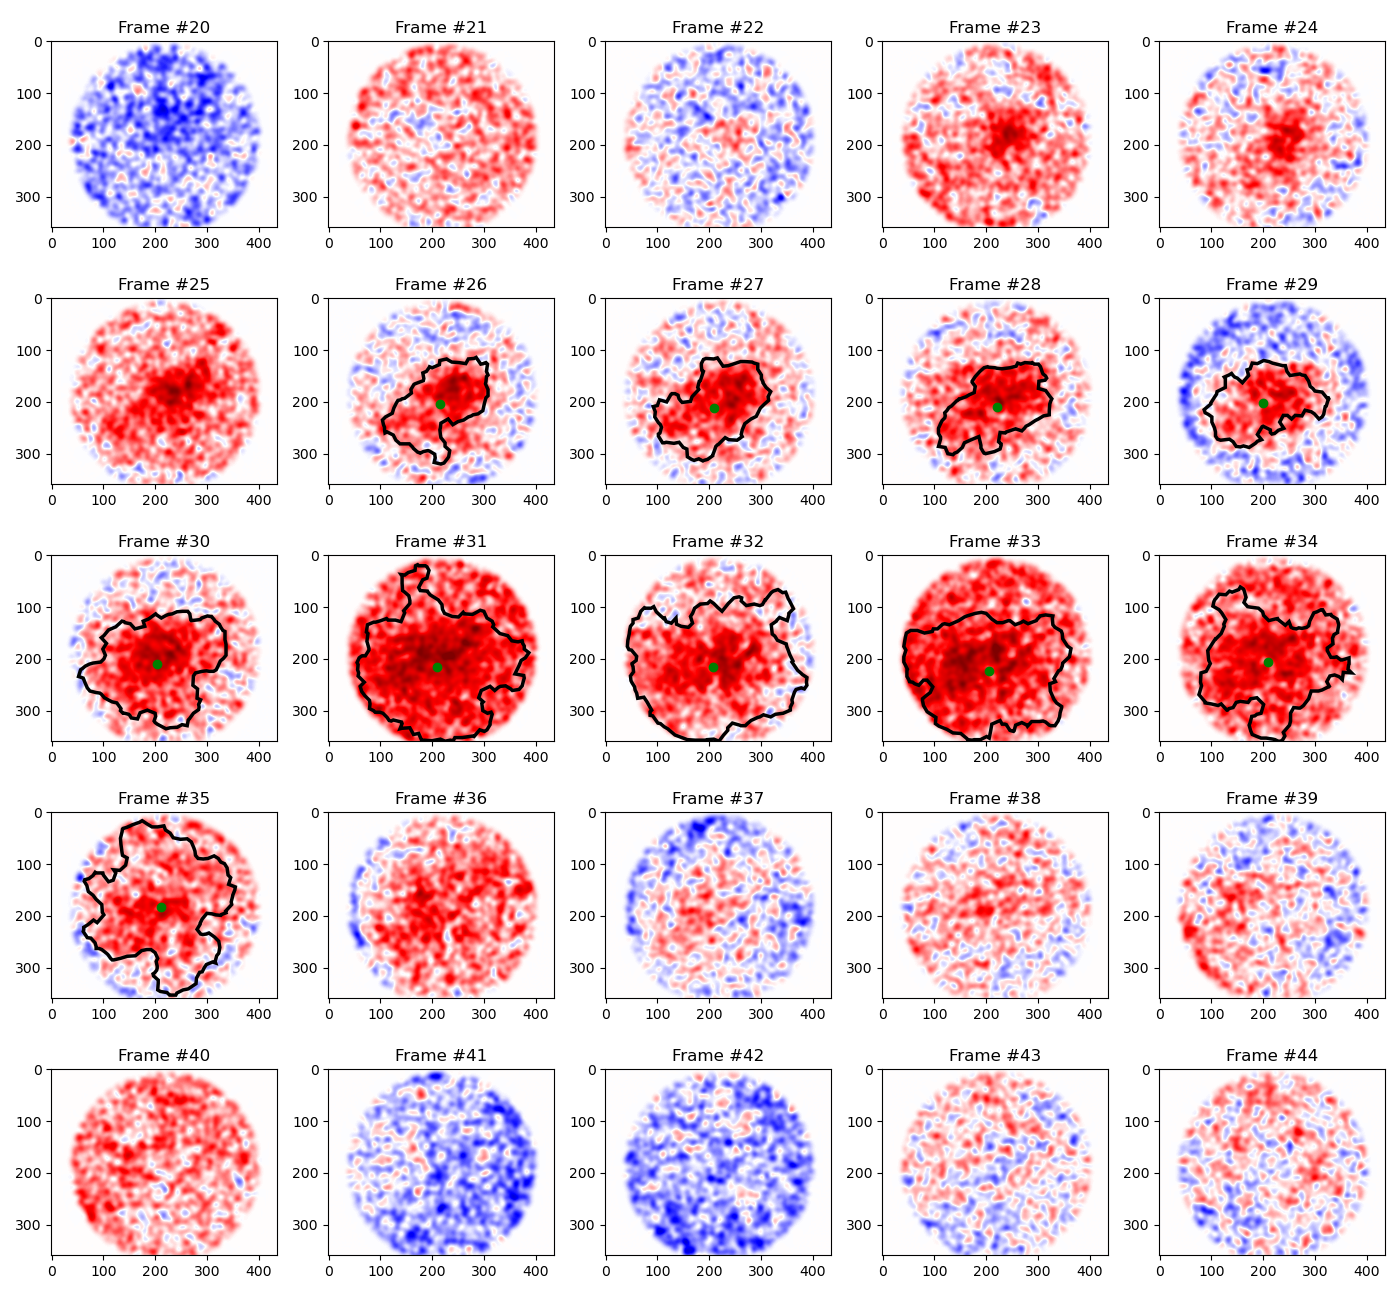

In [48]:
Norm = colors.Normalize(vmax=.5, vmin=-.5)
fig, axs = plt.subplots(5,5, figsize=(14,13), tight_layout=True)
for k in range(20, 45): ### Plot the background fluorescence intensity smoothed
    axs[(k-20)//5, (k-20)%5].imshow(img.gaussian_filter(trial[k], sigma=5, mode='constant'), cmap='seismic', norm=Norm)
    axs[(k-20)//5, (k-20)%5].set_title(f'Frame #{k}')

#for i,j in enumerate(test_mc[ind_wave]['trace']): ### Plots the points
#    axs[(j-20)//5, (j-20)%5].plot(test_mc[ind_wave]['points'][i][:,1], test_mc[ind_wave]['points'][i][:,0], 'k.', alpha=.5)

for i,j in enumerate(test_mc[ind_wave]['trace']): ### Plot the contour of each cluster
    x, y = test_mc[ind_wave]['alpha shapes'][i].exterior.xy
    mpl_poly = MplPolygon(list(zip(y,x)), closed=True, edgecolor='k', facecolor='none', label='contour', linewidth=2.5)
    axs[(j-20)//5, (j-20)%5].add_patch(mpl_poly)
    #axs[(j-20)//5, (j-20)%5].plot(Centre[0,1], Centre[0,0], 'go')
    axs[(j-20)//5, (j-20)%5].plot(Centre[i,1], Centre[i,0], 'go')
    #axs[(j-20)//5, (j-20)%5].plot(Centre[:i+1,1], Centre[:i+1,0], 'g')
    #if i>0:
    #    axs[(j-20)//5, (j-20)%5].plot(Centre[i,1], Centre[i,0], 'gv')

### Centroid dynamics

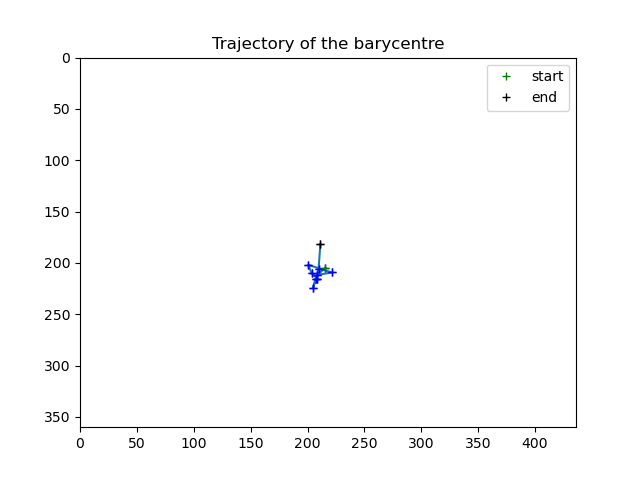

In [49]:
fig, ax = plt.subplots()
ax.set_title('Trajectory of the barycentre')
ax.plot(Centre[:,1], Centre[:,0])
ax.plot(Centre[:,1], Centre[:,0], 'b+')
ax.plot(Centre[1:-1,1], Centre[1:-1,0], 'b+')
ax.plot(Centre[0,1], Centre[0,0], 'g+', label='start')
ax.plot(Centre[-1,1], Centre[-1,0], 'k+', label='end')
ax.set_xlim(0,Ny)
ax.set_ylim(0,Nx)
ax.invert_yaxis()
ax.legend()

In [50]:
Dist = np.linalg.norm(np.diff(Centre,axis=0), axis=1)

Speed = Dist*Fs[condition]*pixel_spacing[condition]/1000 #m/s

Theta = np.arctan2(np.diff(Nx-Centre[:,0]), np.diff(Centre[:,1]))


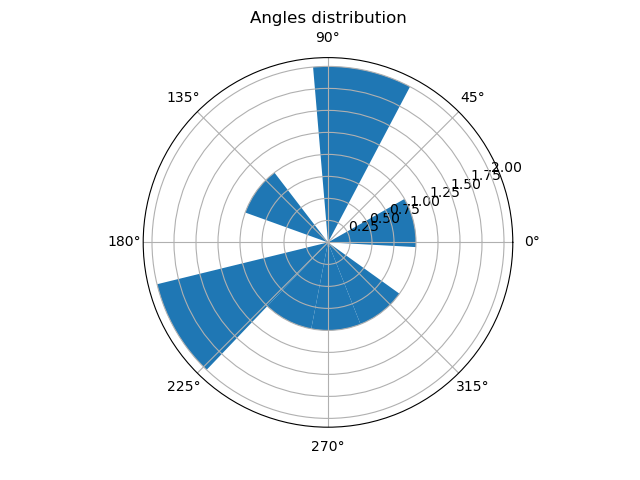

In [51]:
plt.figure()
ax1 = plt.subplot(111, projection='polar')
ax1.set_title('Angles distribution')
ax1.hist(Theta, bins=10)
plt.show()


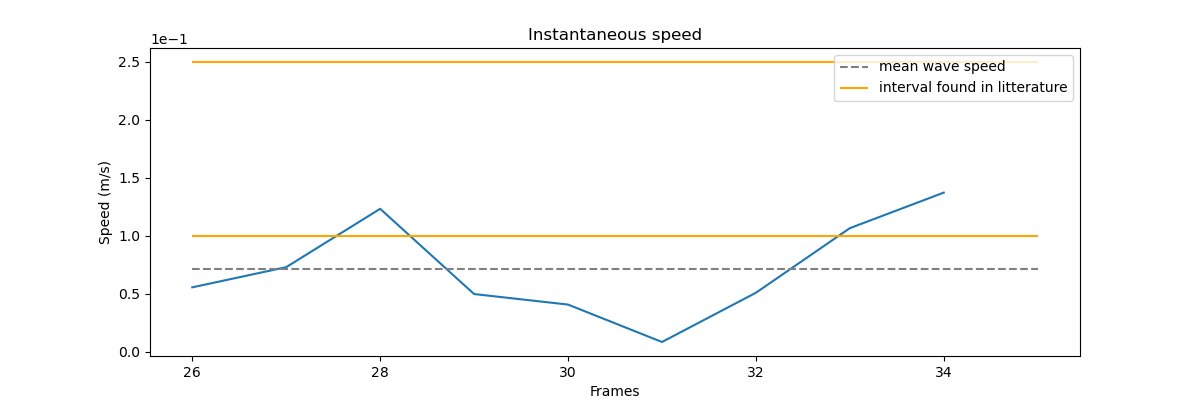

In [52]:
valid_frames=test_mc[ind_wave]['trace']
plt.figure(figsize=(12,4))
plt.title('Instantaneous speed')
plt.xlabel('Frames')
plt.ylabel('Speed (m/s)')
plt.plot(valid_frames[:-1],list(Speed))
plt.hlines(np.mean(Speed), valid_frames[0], valid_frames[-1], linestyles='dashed', colors='gray', label="mean wave speed")
plt.hlines(.1, valid_frames[0], valid_frames[-1], linestyles='solid', colors='orange')
plt.hlines(.25, valid_frames[0], valid_frames[-1], linestyles='solid', colors='orange', label='interval found in litterature')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-2))
plt.legend()
plt.show()
